
### Import libraries and modules

In [111]:
import copy
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import create_inputsTable_UTOPIA
from functions.create_rateConstants_tabel import *
from functions.fillInteractions_df_fun import *
from functions.generate_modelObjects import *
from functions.generateRateConstants_particles import *
from functions.solver_SteadyState import *
from functions.extract_results import *
from functions.plot_results import *
from functions.massBalance import *
from functions.exposure_indicators_calculation import *
from functions.generate_MPinputs_table import *
from functions.save_results import *
from functions.loop_CTD_calculation import *
from functions.generate_compartmentFlows_tables import *
from helpers.helpers import *

Set up path for inputs folder

In [112]:
##Set current working directory
cwd=os.getcwd()
inputs_path = cwd+"\inputs"
inputs_path

'c:\\Users\\PradoDomercq\\Documents\\Python Scripts\\UTOPIA_model\\inputs'

### Define run parameters

#### Define microplastics physical properties

In [113]:
MPdensity_kg_m3 = 1580
MP_composition = "PVC"
shape = "sphere"  # Fixed for now
N_sizeBins = 5  # Fixed, should not be changed. The 5 size bins are generated as being one order of magnitude appart and cover the range from mm to nm(i.e. 5000um, 500um, 50um, 5um, 0.5um)
big_bin_diameter_um = 5000  # This size can not be bigger than 10 mm (10000um) or smaller than 1 mm(1000um)
runName = MP_composition

MP_inputs={"MP_composition":MP_composition,"shape":shape,"N_sizeBins":N_sizeBins,"big_bin_diameter_um":big_bin_diameter_um,"runName":runName,"inputs_path":inputs_path}


In [114]:
# write microplastics inputs file
mp_imputFile_name = write_MPinputs_table(
    MPdensity_kg_m3,
    MP_composition,
    shape,
    N_sizeBins,
    big_bin_diameter_um,
    runName,
    inputs_path,
)

#### Define Environmental Characteristics

##### Suspended particulates properties

In [115]:
# From Kooi et al. (2017)
v_a = 2.0e-16  # Volume of 1 algal cell [m-3]
r_a = ((3.0 / 4.0) * (v_a / math.pi)) ** (1.0 / 3.0)  # radius of algae [m]

spm_radius_um = r_a * 1e6
spm_density_kg_m3 = 1388  # REF: Kooi et al. (2017)

##### Compartment properties

In [116]:
comp_impFile_name = "\inputs_compartments.csv"  # Preloaded values, the user should be able to create its own inputs_compartments.csv file (via donwloading the file and typing news values without chaing the structure of the file) when a new file wants to be used the name should be changed here
comp_interactFile_name = (
    "\compartment_interactions.csv"  # Fixed, should not be modified
)

##### Generate model objects (via reading selected input files)

In [117]:
# Generate objects
boxName = "Utopia"  # fixed, do not modify

(
    system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df,
) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)

surfComp_list = [c for c in dict_comp if "Surface" in c]

#### Define Microplastics weathering properties


##### Select fragmentation style
In out approach each particle fractions into fragments of smaller sizes and the distribution is expresses via a fragment size distribution matrix (fsd), as descibed in https://microplastics-cluster.github.io/fragment-mnp/advanced-usage/fragment-size-distribution.html .  

In this matrix the smallest size fraction is in the first possition and we consider no fragmentation for this size class 

Below we define 4 different styles of fragmentation via defining the fsd for each of them. The user can choose form one of the proposed fragmentation styles or define its own fsd by including it in the frag_styles_dict following the structure below.

We provide a slider (to be done) where the user can select a fragmentation style by means of choosing a value of FI (fragmentation index) between 0 and 1 that describe two scenarios :

- Erosive fragmentation (FI=0): In this scenario the particles are being eroded on their surface and therefore most of their mass remain in their same size fraction and samall fraction in going to the samllest size bins. Its representative fsd is: 
  
    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0.99, 0.01, 0, 0, 0],

    [0.999, 0, 0.001, 0, 0],
    
    [0.9999, 0, 0, 0.0001, 0],]

- Sequential fragmentation (FI=1): in this scenario each size fraction breacks down completely into the next smallest size bin.
Its representative fsd is: 

    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0, 1, 0, 0, 0],

    [0, 0, 1, 0, 0],
    
    [0, 0, 0, 1, 0],]

By choosing a value between 0 and 1 the user can select a fragmentation style in between both extremes.

In [118]:
### Substitute by a slider using the new function to generate fsd based on the fragmentation style index: FI
def generate_fsd_matrix(FI):
    # Initialize a 5x5 matrix with zeros
    matrix = np.zeros((5, 5))
    c1=0.2
    c2=0.15
    c3=0.1
    
    matrix[1,0]=1
    matrix[2,0]=1-FI
    matrix[2,1]=FI
    if FI <=0.5:
        matrix[3,1]=FI*2*c1
        matrix[4,1]=FI*2*c2
        matrix[4,2]=FI*2*c3
    else:
        matrix[3,1]=c1-((FI-0.5)*2*c1)
        matrix[4,1]=c2-((FI-0.5)*2*c2)
        matrix[4,2]=c3-((FI-0.5)*2*c3)
    matrix[3,0]=matrix[2,0]+(0.5* matrix[3,1])
    matrix[3,2]=1-matrix[3,0]-matrix[3,1]
    matrix[4,0]=matrix[3,0]+(0.5* matrix[4,1])+(0.25* matrix[4,2])
    matrix[4,3]=1-matrix[4,0]-matrix[4,1]-matrix[4,2]
    
    return matrix


In [119]:
## Select a value for FI in the range 0-1 where:
frag_styles_dict = {0:"erosive_fragmentation",0.5:"mixed_fragmentation",1:"sequential_fragmentation"} ## Slider??
FI=0.5

# Generate the matrix
fsd=generate_fsd_matrix(FI)
print(fsd)

# Verify the sum of each row
row_sums = fsd.sum(axis=1)
print("\nSum of each row:")
for idx, sum_value in enumerate(row_sums):
    print(f"Row {idx + 1}: {sum_value}")

[[0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.5  0.5  0.   0.   0.  ]
 [0.6  0.2  0.2  0.   0.  ]
 [0.7  0.15 0.1  0.05 0.  ]]

Sum of each row:
Row 1: 0.0
Row 2: 1.0
Row 3: 1.0
Row 4: 1.0
Row 5: 1.0


In [120]:
frag_style = frag_styles_dict[FI]
frag_style ### We need this now for the save fiction but should be substituted for FI=x? so that we can choose any value in the range 0-1

'mixed_fragmentation'

In [121]:
sizes = [list(model_lists["dict_size_coding"].keys())]
fsd_df = pd.DataFrame(fsd, index=sizes, columns=sizes)

# Save the fsd matrix
fsd_filename = os.path.join(inputs_path, "fsd.csv")
fsd_df.to_csv(fsd_filename)

##### Define Weathering processes input parameters

##### Degradation half time: thalf_deg_d

The model provides a default value for degradation time of Free MPs taken from Domercq et al. 2021 in the file (t_half_deg_free.csv):
 
The assumptions made for the definition of these degradation times: (NEW assumptions) 
    - Heteroaggregated particles degrade 10 times slower than the free MPs
    - Biofouled particles degrade 2 times faster than the free MPs
    - Degradation rates are all the same for the different compartments??

If the user want to provide its own values of thalf_deg_d the values can be modified in the following cells

In [162]:
t_half_deg_free= 5000  # in days
heter_deg_rate= 10
biof_deg_rate= 1/2


In [163]:
t_half_deg_heter=t_half_deg_free*heter_deg_rate
t_half_deg_biof=t_half_deg_free*biof_deg_rate
t_half_deg_biofHeter=t_half_deg_free*biof_deg_rate*heter_deg_rate

In [164]:
thalf_deg_d_dict = {
     "freeMP": t_half_deg_free,
     "heterMP": t_half_deg_heter,
     "biofMP": t_half_deg_biof,
     "heterBiofMP": t_half_deg_biofHeter,
 } 

print(thalf_deg_d_dict)

t_half_deg_filename = os.path.join(inputs_path, "t_half_deg.csv")
t_half_deg_df = pd.DataFrame(list(thalf_deg_d_dict.items()), columns=['MP_form', 'thalf_deg_d'])
t_half_deg_df.to_csv(t_half_deg_filename,index=False)

{'freeMP': 5000, 'heterMP': 50000, 'biofMP': 2500.0, 'heterBiofMP': 25000.0}


In [165]:
# Read the CSV file into a DataFrame
t_half_deg_filename = os.path.join(inputs_path, "t_half_deg.csv")
t_half_deg_df = pd.read_csv(t_half_deg_filename)

# Convert the DataFrame to a dictionary
thalf_deg_d_dict = t_half_deg_df.set_index("MP_form")["thalf_deg_d"].to_dict()

#### Heteroaggregation attachment efficiency: alpha_heter.

In [126]:
alpha_heter_filename = os.path.join(inputs_path, "alpha_heter.csv")
alpha_heter_df = pd.read_csv(alpha_heter_filename)
alpha_hetr_dict = alpha_heter_df.set_index("MP_form")["alpha_heter"].to_dict()

In [166]:
alpha_hetr_dict

{'freeMP': '0.01', 'heterMP': 'NAN', 'biofMP': '0.02', 'heterBiofMP': 'NAN'}

#### Timescales of fragmentation

The fragmentation timescales are deteremined from the stablished fragmentation half time of 36.5 days for the biggest size fraction in free form in the surface water compartments following the parameters chosen in Domercq et al. 2021.

In UTOPIA we include fragmentation of the heteroaggregated MPs as being 100 slower than fragmentation of the Free MPs and breackup of biofouled and heteroaggregated will be two times slowed of those only heteroaggregated, following the same assumption as for free and biofouled. These values are used in the Domercq et al. 2021 paper and they are asumptions made from lack of current knowlegde

In [127]:
t_frag_gen_FreeSurfaceWater = 36.5  # in days

In [128]:
process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
    save_op="save"
)

#### Define emission scenario

Choose input flow (in g per second) and define in wich form and size the particles are released into the environment and specify the input flow for each compartment

In [129]:
# Size fraction:
# for the preloaded scenario:
# a= 0.5 um
# b= 5 um
# c= 50 um
# d= 500 um
# e= 5000 um
import string

size_codes = [letter for letter in string.ascii_lowercase[0:N_sizeBins]]
size_dict = dict(zip(size_codes, model_lists["dict_size_coding"].values()))

# Aggregation state (MP form):
# A= Free MP
# B= heteroaggregatedMP
# C= biofouled MP
# D= biofouled and heteroaggregated MP
MPforms_list = ["freeMP", "heterMP", "biofMP", "heterBiofMP"]
particle_forms_coding = dict(zip(MPforms_list, ["A", "B", "C", "D"]))
MP_form_dict_reverse = {v: k for k, v in particle_forms_coding.items()}

##### Select size bin and form

In [130]:
size_bin = "e"  # Chosse from size_dict
MP_form = "freeMP"  # Choose from MPforms_list above

##### Type input flow in g/s

If inputs are only made to one compartment:

In [131]:
emiss_comp = "Coast_Surface_Water"  # Select compartment from the compartment list
input_flow_g_s = 1  # Choose input flow (in g per second)

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Beaches_Soil_Surface": 0,
    "Beaches_Deep_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Impacted_Soil_Surface": 0,
    "Impacted_Soil": 0,
    "Air": 0,
}

q_mass_g_s_dict[emiss_comp] = input_flow_g_s

If emissions are made to several compartments type the input flows corresponding to the specific compartments in the following dictionary:

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

If inputs are made to different size classess and MP forms the following dictionary has to be used:


In [132]:
input_flow_filename = os.path.join(inputs_path, "inputFlows.csv")
input_flows_df = pd.DataFrame(
    list(q_mass_g_s_dict.items()), columns=["compartment", "q_mass_g_s"]
)
input_flows_df.to_csv(input_flow_filename, index=False)

In [133]:
# Generate dict of emission flows
particle_compartmentCoding = dict(
    zip(
        model_lists["compartmentNames_list"],
        list(range(len(model_lists["compartmentNames_list"]))),
    )
)
comp_dict_inverse = {v: k for k, v in particle_compartmentCoding.items()}

sp_imputs = []
q_mass_g_s = []
for compartment in q_mass_g_s_dict.keys():

    sp_imputs.append(
        size_bin
        + particle_forms_coding[MP_form]
        + str(particle_compartmentCoding[compartment])
        + "_"
        + boxName
    )
    q_mass_g_s.append(q_mass_g_s_dict[compartment])

imput_flows_g_s = dict(zip(sp_imputs, q_mass_g_s))

q_num_s = [
    mass_to_num(v, p.Pvolume_m3, p.Pdensity_kg_m3) if v != 0 else 0
    for k, v in zip(imput_flows_g_s.keys(), imput_flows_g_s.values())
    for p in system_particle_object_list
    if k == p.Pcode
]

# imput_flows_num_s = dict(zip(sp_imputs, q_num_s))


In [134]:
emission_inputs={"size_bin":size_bin, "MP_form":MP_form, "emiss_comp":emiss_comp, "imput_flows_g_s":imput_flows_g_s}

## Model Run Summary

In [135]:
saveName = (
    MP_composition
    + "_MP_Emissions_"
    + MP_form
    + "_"
    + str(size_dict[size_bin])
    + "_nm_"
    + frag_style
)

# Print model run summary

print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print("Selected fragmentation style: ", frag_style)


Model run: 
Emissions flow (g/s):  1
Receiving compartment/s:  Coast_Surface_Water
Emitted MP density (kg/m3):  1580
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
Selected fragmentation style:  mixed_fragmentation


### Run Model

In [136]:

"""Estimate rate constants per particle"""

for particle in system_particle_object_list:
    generate_rateConstants(particle, spm, dict_comp, fsd,process_inputs_df)


## create rate constants table:
RC_df = create_rateConstants_table(system_particle_object_list)
df4 = RC_df.fillna(0)

"""Build Matrix of interactions"""

interactions_df = fillInteractions_fun_OOP(
    system_particle_object_list, SpeciesList, surfComp_list
)


"""SOLVE SYSTEM OF ODES"""


R, PartMass_t0 = solve_ODES_SS(
    system_particle_object_list=system_particle_object_list,
    q_num_s=0,
    imput_flows_g_s=imput_flows_g_s,
    interactions_df=interactions_df,
)

# Reformat results (R) dataframe
R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

Results = R[
    [
        "Compartment",
        "MP_Form",
        "Size_Fraction_um",
        "mass_g",
        "number_of_particles",
        "concentration_g_m3",
        "concentration_num_m3",
    ]
]

# Solve mass balance and print result
massBalance(R, system_particle_object_list, q_mass_g_s)


# Test that there are no negative results
for i, idx in zip(R["mass_g"], R.index):
    if i < 0:
        print("negative values in the solution for " + idx)
    else:
        pass

# Estimate mass and number fractions and extract ranking tables of the species with higest fractions to understand the distribution of the particles in the system by mass and number of particles

Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

# Organise results in dictionary for plotting

Results_comp_dict = extract_by_comp(
    Results_extended.reset_index(), particle_compartmentCoding
)
Results_comp_organiced = extract_by_aggSt(Results_comp_dict, particle_forms_coding)

# Mass distribution by compartment
mass_frac_100 = []
num_frac_100 = []
mass_conc_g_m3 = []
num_conc = []
for comp in list(dict_comp.keys()):
    mass_frac_100.append(
        sum(Results_extended[Results_extended["Compartment"] == comp]["mass_fraction"])
        * 100
    )
    num_frac_100.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp]["number_fraction"]
        )
        * 100
    )
    mass_conc_g_m3.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp][
                "concentration_g_m3"
            ]
        )
    )
    num_conc.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp][
                "concentration_num_m3"
            ]
        )
    )

mass_dist_comp = pd.DataFrame(columns=["Compartments"])
mass_dist_comp["Compartments"] = list(dict_comp.keys())
mass_dist_comp["%_mass"] = mass_frac_100
mass_dist_comp["%_number"] = num_frac_100
mass_dist_comp["Concentration_g_m3"] = mass_conc_g_m3
mass_dist_comp["Concentration_num_m3"] = num_conc

### MASS BALANCE PER COMPARTMENT###

# Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)

from functions.generate_compartmentFlows_tables import *

# Estimate outflows in mass (g/s) amd number/second
(tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
    system_particle_object_list, dict_comp
)


# Estimate imput flows from transport from other compartments
(tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
    tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
)
# Decode index in input and output flow tables
flows_dict_mass = dict()
flows_dict_mass["input_flows"] = {}
flows_dict_mass["output_flows"] = {}

# Decode index in input and output flow tables
for comp in tables_outputFlows.keys():
    df1 = tables_outputFlows[comp].copy()
    MP_size_df1 = []
    MP_form_df1 = []
    for x in df1.index:
        MP_size_df1.append(size_dict[x[0]])
        MP_form_df1.append(MP_form_dict_reverse[x[1:2]])

    df1.insert(0, "MP_size", MP_size_df1)
    df1.insert(1, "MP_form", MP_form_df1)
    flows_dict_mass["output_flows"][comp] = df1

for comp in tables_inputFlows:
    df2 = tables_inputFlows[comp].copy()
    MP_size_df2 = []
    MP_form_df2 = []
    for y in df2.index:
        MP_size_df2.append(size_dict[y[0]])
        MP_form_df2.append(MP_form_dict_reverse[y[1:2]])
    df2.insert(0, "MP_size", MP_size_df2)
    df2.insert(1, "MP_form", MP_form_df2)
    flows_dict_mass["input_flows"][comp] = df2

## Compartment mass balance

comp_mass_balance = {}
for comp in list(dict_comp.keys()):
    comp_mass_balance[comp] = compartment_massBalance(
        comp=comp,
        tables_outputFlows=tables_outputFlows,
        PartMass_t0=PartMass_t0,
        comp_dict_inverse=comp_dict_inverse,
        dict_comp=dict_comp,
        tables_inputFlows=tables_inputFlows,
    )

# Print compartment mass balance table
comp_mass_balance_df = pd.DataFrame.from_dict(comp_mass_balance, orient="index")
print(comp_mass_balance_df)

comp_mass_balance_df["Mass balance"] = [
    comp_mass_balance_df["Inflow"][c] - comp_mass_balance_df["Outflow"][c]
    for c in comp_mass_balance_df.index
]

# Add total steady state mass and number of particles concentrations to dataframe

# comp_mass_balance_df["Total Mass (g)"] = [sum(Results_comp_dict[c].mass_g) for c in comp_mass_balance_df.index]
# comp_mass_balance_df["Total Number of Particles"] = [sum(Results_comp_dict[c].number_of_particles) for c in comp_mass_balance_df.index]
comp_mass_balance_df["Concentration (g/m3)"] = [
    sum(Results_comp_dict[c].concentration_g_m3) for c in comp_mass_balance_df.index
]
comp_mass_balance_df["Concentration (N/m3)"] = [
    sum(Results_comp_dict[c].concentration_num_m3) for c in comp_mass_balance_df.index
]


Difference inflow-outflow = -8.881784197001252e-16
                               Inflow       Outflow
Ocean_Surface_Water      3.631483e+00  3.631483e+00
Ocean_Mixed_Water        3.635686e+00  3.635686e+00
Ocean_Column_Water       4.769470e-03  4.769470e-03
Coast_Surface_Water      4.490625e+00  4.490604e+00
Coast_Column_Water       4.575831e+00  4.575831e+00
Surface_Freshwater       5.044678e-06  5.044678e-06
Bulk_Freshwater          5.047627e-06  5.047627e-06
Sediment_Freshwater      1.165167e-08  1.165167e-08
Sediment_Ocean           4.468952e-03  4.468952e-03
Sediment_Coast           1.081013e+00  1.081013e+00
Beaches_Soil_Surface     9.237529e-05  5.987397e-06
Beaches_Deep_Soil        8.638790e-05  1.509928e-05
Background_Soil_Surface  1.246980e-07  7.952609e-09
Background_Soil          1.167454e-07  1.950136e-08
Impacted_Soil_Surface    2.397704e-09  6.227569e-10
Impacted_Soil            1.774947e-09  2.923753e-10
Air                      1.906860e-07  1.906860e-07


In [140]:
def extract_inflows_outflows(flows_dict_mass, comp, MP_form, MP_size):

    # function to extract the input and output flows of the system (cell selection)

    # extract inflows
    df_i = flows_dict_mass["input_flows"][comp]
    df_ii = df_i.loc[(df_i["MP_form"] == MP_form) & (df_i["MP_size"] == MP_size)]
    df_iii = df_ii.drop(["MP_size", "MP_form"], axis=1)
    list_iflows = [k for k in df_iii]
    list_inflow_val = [sum(df_iii[col]) for col in list_iflows]
    inflow_p = [round((v / sum(list_inflow_val)) * 100, 4) for v in list_inflow_val]

    pd_inputFlows = dict(zip(list_iflows,list_inflow_val ))
    # pd.DataFrame(
    #     {"Inflows": list_iflows, "Rate_g_s": list_inflow_val, "%": inflow_p}
    # )

    # extract outflows
    df_o = flows_dict_mass["output_flows"][comp]
    df_oo = df_o.loc[(df_o["MP_form"] == MP_form) & (df_o["MP_size"] == MP_size)]
    df_oo.reset_index(drop=True, inplace=True)
    df_ooo = df_oo.drop(["MP_size", "MP_form"], axis=1)

    outflow_val = [
        sum(df_ooo[ko]) if type(df_ooo[ko][0]) != list else sum(df_ooo[ko][0])
        for ko in df_ooo
    ]
    df_ooo.loc[0] = outflow_val
    list_outflows = [ko for ko in df_ooo.columns if (df_ooo[ko] != 0).any()]
    list_outflow_val = [
        value for column in df_ooo.columns for value in df_ooo[column] if value != 0
    ]
    outflow_p = [round((v / sum(list_outflow_val)) * 100, 4) for v in list_outflow_val]

    pd_outflows = dict(zip(list_outflows, (list_outflow_val, outflow_p)))
    # pd.DataFrame(
    #     {"Outflows": list_outflows, "Rate_g_s": list_outflow_val, "%": outflow_p}
    # )

    return (pd_inputFlows, pd_outflows)

In [141]:
Results_extended

,Compartment,MP_Form,Size_Fraction_um,mass_g,number_of_particles,concentration_g_m3,concentration_num_m3,mass_fraction,number_fraction
species,,,,,,,,,
aA0_Utopia,Ocean_Surface_Water,freeMP,0.5,2.500923e-06,2.418436e+07,1.454025e-21,1.406067e-08,2.894984e-15,3.359848e-14
bA0_Utopia,Ocean_Surface_Water,freeMP,5.0,4.014538e-07,3.882128e+03,2.334034e-22,2.257051e-12,4.647094e-16,5.393305e-18
cA0_Utopia,Ocean_Surface_Water,freeMP,50.0,1.441359e-10,1.393820e-03,8.379997e-26,8.103602e-19,1.668469e-19,1.936385e-24
dA0_Utopia,Ocean_Surface_Water,freeMP,500.0,1.287493e-15,1.245028e-11,7.485426e-31,7.238537e-27,1.490359e-24,1.729674e-32
eA0_Utopia,Ocean_Surface_Water,freeMP,5000.0,4.956934e-15,4.793441e-14,2.881938e-30,2.786884e-29,5.737980e-24,6.659360e-35
...,...,...,...,...,...,...,...,...,...
aD16_Utopia,Air,heterBiofMP,0.5,4.418442e+01,4.272711e+14,1.443935e-17,1.396311e-04,5.114640e-08,5.935927e-07
bD16_Utopia,Air,heterBiofMP,5.0,8.393130e-02,8.116302e+08,2.742853e-20,2.652386e-10,9.715604e-11,1.127569e-12
cD16_Utopia,Air,heterBiofMP,50.0,2.301414e-06,2.225507e+01,7.520960e-25,7.272899e-18,2.664039e-15,3.091819e-20


#### Mass and particle number distribution per compartment

In [142]:
mass_dist_comp

,Compartments,%_mass,%_number,Concentration_g_m3,Concentration_num_m3
0,Ocean_Surface_Water,1.521096e-04,1.598390e-03,7.639804e-13,6.689123e+00
1,Ocean_Mixed_Water,3.045616e-03,3.200140e-02,7.648405e-13,6.696154e+00
2,Ocean_Column_Water,1.057650e-01,1.120691e+00,8.870717e-13,7.831837e+00
3,Coast_Surface_Water,7.316732e-05,7.188151e-04,2.860086e-11,2.341207e+02
4,Coast_Column_Water,1.465646e-03,1.439302e-02,2.864579e-11,2.343930e+02
5,Surface_Freshwater,8.695620e-11,8.702405e-10,8.300535e-17,6.921586e-04
6,Bulk_Freshwater,8.700537e-10,8.707006e-09,8.305228e-17,6.925246e-04
7,Sediment_Freshwater,3.425212e-07,3.207905e-06,3.269588e-12,2.551455e+01
8,Sediment_Ocean,6.247046e-01,6.081893e+00,5.239521e-07,4.250270e+06
9,Sediment_Coast,9.925743e+01,9.267673e+01,9.710832e-04,7.554834e+08


#### Size fraction distribution

In [143]:
size_distr={}
for size in [0.5, 5, 50, 500, 5000]:
    size_distr[size]=round(sum(Results_extended[Results_extended["Size_Fraction_um"] == size]["mass_g"])/sum(Results_extended["mass_g"])*100,2)

pd.DataFrame.from_dict(size_distr, orient="index", columns=["% of total mass"])

,% of total mass
0.5,8.61
5.0,1.83
50.0,1.20
500.0,0.59
5000.0,87.76


In [144]:
form_distr={}
for form in ["freeMP","heterMP", "biofMP", "heterBiofMP"]:
    form_distr[form]=round(sum(Results_extended[Results_extended["MP_Form"] == form]["mass_g"])/sum(Results_extended["mass_g"])*100,2)

pd.DataFrame.from_dict(form_distr, orient="index", columns=["% of total mass"])

,% of total mass
freeMP,0.00
heterMP,99.12
biofMP,0.00
heterBiofMP,0.88


### Mass and number distribution heatmaps

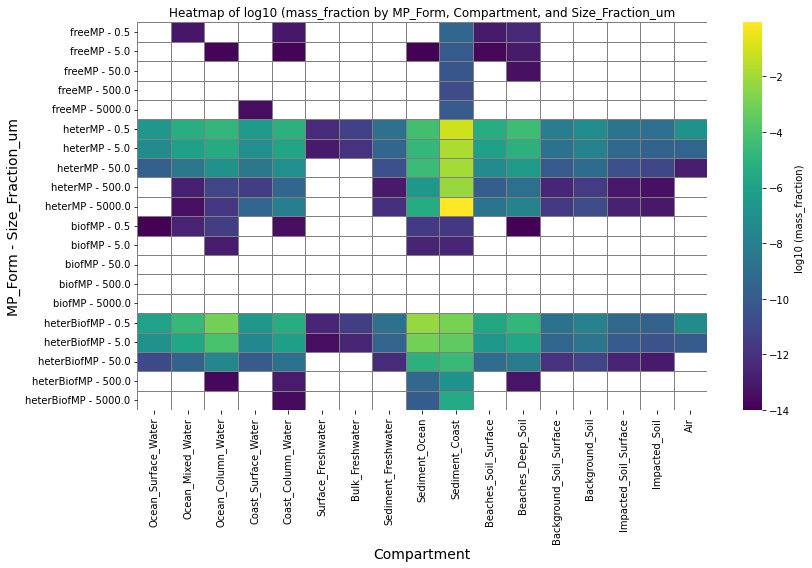

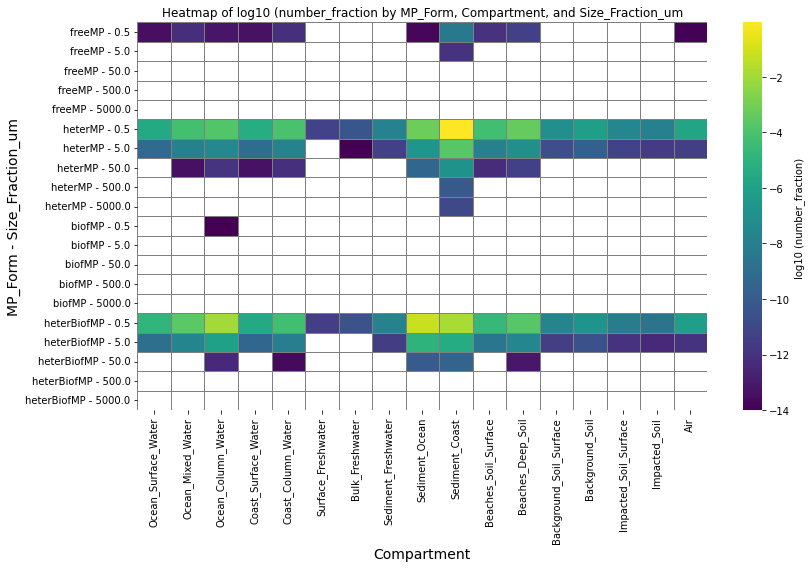

(<Figure size 864x576 with 2 Axes>,
 'Heatmap of log10 (number_fraction by MP_Form, Compartment, and Size_Fraction_um')

In [145]:
plot_fractionDistribution_heatmap(Results_extended, fraction="mass_fraction")
plot_fractionDistribution_heatmap(Results_extended, fraction="number_fraction")

### Exposure indicators

Environmentally Dispersed Mass Fractions through Air = 4.800531179881525e-07
Environmentally Dispersed Mass Fractions through Ocean_Mixed_Water = 2.0477227812157268e-07
Environmentally Dispersed Mass Fractions through Ocean_Surface_Water = 6.142402613045502e-10
φ1 for mass = 6.854396363710297e-07
Environmentally Dispersed Particle Number Fractions through Air = 478969
Environmentally Dispersed Particle Number Fractions through Ocean_Mixed_Water = 185392
Environmentally Dispersed Particle Number Fractions through Ocean_Surface_Water = 556
φ1 for particle number = 664917.9429728627
Remotely transferred fraction to Ocean_Surface_Water = 1.436974170264483e-12
Remotely transferred fraction to Ocean_Column_Water = 2.5595736426493925e-10
Remotely transferred fraction to Sediment_Ocean = 1.2958725421534683e-07
Remotely transferred fraction to Beaches_Soil_Surface = 8.988436775023842e-09
Total remotely transferred mass fraction = 1.3883308532880586e-07


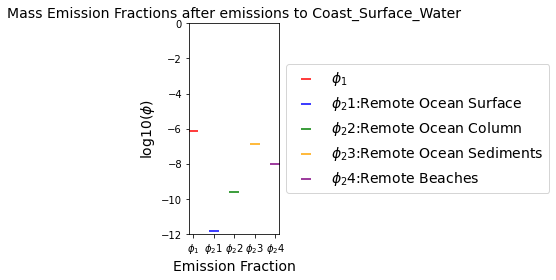

Overall mass persistence (years): 197
Overall particle number persistence (years): 194
Overall residence time is calculated assuming the model boundaries to be at 100 m depth into the Ocean, 30 cm into the sediments and 0.1 m into the soil. Particles travelling deeper are considered losses
Overall mass residence time (years): 27.2
Overall particle number residence time (years): 26.0
Overall residence time of size 0.5 um (years): 26.01
Overall residence time of size 5.0 um (years): 26.2
Overall residence time of size 50.0 um (years): 27.23
Overall residence time of size 500.0 um (years): 26.96
Overall residence time of size 5000.0 um (years): 24.04
Characteristic mass travel distance (CDT):  2252.7  km
Characteristic particle number travel distance (CDT):  4506.7  km


In [146]:

# For estimating exposure indicators we need to make emissions to targeted compartments.

# Run model with emissions to specific compartments to estimate the emission fractions
from functions.model_run_by_comp import *

model_results = {}
dispersing_comp_list = [
    "Air",
    "Ocean_Mixed_Water",
    "Ocean_Surface_Water",
]

for dispersing_comp in dispersing_comp_list:
    model_results[dispersing_comp] = run_model_comp(
        dispersing_comp,
        input_flow_g_s,
        interactions_df,
        MP_form,
        size_bin,
        particle_forms_coding,
        particle_compartmentCoding,
        system_particle_object_list,
        comp_dict_inverse,
        dict_comp,
        size_dict,
        MP_form_dict_reverse,
        surfComp_list,
    )


#### EXPOSURE INDICATORS ####
from functions.emission_fractions_calculation import *


# Estimate emission fractions for the setted emission scenario

emission_fractions_mass_data = emission_fractions_calculations(
    Results_extended,
    model_results,
    dispersing_comp_list,
    dict_comp,
    input_flow_g_s,
    q_num_s,
    size_dict,
    emiss_comp,
)


plot_emission_fractions(emission_fractions_mass_data, emiss_comp)


# Overall persistance (Pov) and Overall residence time (Tov) in years:
print_output="True"

(
    Pov_mass_years,
    Pov_num_years,
    Pov_size_dict_sec,
    Tov_mass_years,
    Tov_num_years,
    Tov_size_dict_sec,
) = Exposure_indicators_calculation(
    tables_outputFlows,
    tables_outputFlows_number,
    Results_extended,
    size_dict,
    dict_comp,
    system_particle_object_list,
    print_output
)

# Caracteristic travel distance (CDT) (m):

# To calculate CTD we need to estimate it by emitting into the especific mobile compartment. We will calculate CTD derived from emmiting to each compartment and taking the higest value:
CTD_mass_list = []
CTD_number_list = []


for CDT_comp in [
    "Ocean_Surface_Water",
    "Ocean_Mixed_Water",
    "Coast_Surface_Water",
    "Coast_Column_Water",
    "Surface_Freshwater",
    "Bulk_Freshwater",
    "Air",
]:
    # input flow (in g per second) for each compartment the User should specify here the input flows per compartment
    q_mass_g_s_dict_CTD = {
        "Ocean_Surface_Water": 0,
        "Ocean_Mixed_Water": 0,
        "Ocean_Column_Water": 0,
        "Coast_Surface_Water": 0,
        "Coast_Column_Water": 0,
        "Surface_Freshwater": 0,
        "Bulk_Freshwater": 0,
        "Sediment_Freshwater": 0,
        "Sediment_Ocean": 0,
        "Sediment_Coast": 0,
        "Beaches_Soil_Surface": 0,
        "Beaches_Deep_Soil": 0,
        "Background_Soil_Surface": 0,
        "Background_Soil": 0,
        "Impacted_Soil_Surface": 0,
        "Impacted_Soil": 0,
        "Air": 0,
    }
    q_mass_g_s_dict_CTD[CDT_comp] = input_flow_g_s

    sp_imputs_CTD = []
    q_mass_g_s_CTD = []
    for compartment in q_mass_g_s_dict_CTD.keys():
        sp_imputs_CTD.append(
            size_bin
            + particle_forms_coding[MP_form]
            + str(particle_compartmentCoding[compartment])
            + "_"
            + boxName
        )
        q_mass_g_s_CTD.append(q_mass_g_s_dict_CTD[compartment])

    imput_flows_g_s_CTD = dict(zip(sp_imputs_CTD, q_mass_g_s_CTD))

    CTD_km = model_run_CTD(
        system_particle_object_list,
        CDT_comp,
        imput_flows_g_s_CTD,
        interactions_df,
        q_mass_g_s_CTD,
        size_dict,
        MP_form_dict_reverse,
        comp_dict_inverse,
        dict_comp,
    )

    CTD_mass_list.append(CTD_km[0])
    CTD_number_list.append(CTD_km[1])

CTD_df = pd.DataFrame(
    index=[
        "Ocean_Surface_Water",
        "Ocean_Mixed_Water",
        "Coast_Surface_Water",
        "Coast_Column_Water",
        "Surface_Freshwater",
        "Bulk_Freshwater",
        "Air",
    ]
)

CTD_df["CTD_mass_km"] = CTD_mass_list
CTD_df["CTD_particle_number_km"] = CTD_number_list

print(
    "Characteristic mass travel distance (CDT): ",
    round(CTD_df["CTD_mass_km"].max(), 1),
    " km",
)

print(
    "Characteristic particle number travel distance (CDT): ",
    round(CTD_df["CTD_particle_number_km"].max(), 1),
    " km",
)


### Extract input and output flows per compartment
 So far only implemented for mass flows (g/s)-- HAS TO BE FIXED!!!

In [147]:
for comp in dict_comp.keys():
    pd_inputFlows, pd_outflows=extract_inflows_outflows_comp(flows_dict_mass, comp)
    print(comp)
    print(pd_inputFlows)
    print(pd_outflows)

Ocean_Surface_Water
                 Inflows      Rate_g_s        %
0               k_rising  0.000000e+00   0.0000
1               k_mixing  3.630851e+00  99.9826
2  k_advective_transport  6.320789e-04   0.0174
3       k_dry_deposition  1.063532e-07   0.0000
4       k_wet_deposition  0.000000e+00   0.0000
                     Outflows      Rate_g_s        %
0            k_discorporation  3.787219e-07   0.0000
1         k_heteroaggregation  2.799243e-11   0.0000
2  k_heteroaggregate_breackup  1.406286e-12   0.0000
3                k_biofouling  3.098731e-04   0.0085
4       k_advective_transport  1.688397e-05   0.0005
5                  k_settling  4.697897e-03   0.1294
6                    k_mixing  3.626768e+00  99.8616
7         k_sea_spray_aerosol  7.300257e-11   0.0000
Ocean_Mixed_Water
                 Inflows  Rate_g_s        %
0             k_settling  0.004698   0.1292
1               k_mixing  3.626778  99.7550
2               k_rising  0.000000   0.0000
3  k_advective_transp

### Uncertainty and sensitivity analysis

In [148]:
import monaco as mc

# Import the statistical distributions from scipy.stats that you will be using.
# These must be rv_discrete or rv_continuous functions.
# See https://docs.scipy.org/doc/scipy/reference/stats.html for a complete list.
from scipy.stats import randint, rv_discrete, lognorm, uniform

add other inputs to add uncertainty to the fragmentation rates (i.e. heteroagg_frac_factor=100, biofouled_frag_factor=1/2)
include the explosiveness_index to the montecarlo simulation EI)
Degradation factors:
t_half_deg_free
heter_deg_rate
biof_deg_rate


In [150]:
# The preprocessing function should only take in an Case object, and extract the
# values from inside it in order to build the inputs for the run function.
def template_preprocess(case):
    
    # Variables that will be passed to the run function and will be sampled
    MPdensity = case.invals['MPdensity'].val
    t_frag_gen_FreeSurfaceWater = case.invals['t_frag_gen_FreeSurfaceWater'].val
    FI=case.invals['FI'].val
    t_half_deg_free=case.invals['t_half_deg_free'].val
    heter_deg_rate=case.invals['heter_deg_rate'].val
    biof_deg_rate=case.invals['biof_deg_rate'].val
    
    
    # Other fixed variables
    MP_inputs=case.constvals["MP_inputs"]
    

    return (
        MPdensity,t_frag_gen_FreeSurfaceWater,FI,MP_inputs,emission_inputs,t_half_deg_free,heter_deg_rate,biof_deg_rate
    )


In [151]:
# The run function input arguments need to match up with the outputs in the unpacked
# tuple from your preprocessing function
def UTOPIA_model_run(MPdensity,t_frag_gen_FreeSurfaceWater,FI,MP_inputs,emission_inputs,t_half_deg_free,heter_deg_rate,biof_deg_rate):
    # write microplastics inputs file
    mp_imputFile_name = write_MPinputs_table(
    MPdensity,
    big_bin_diameter_um=MP_inputs["big_bin_diameter_um"],
    MP_composition=MP_inputs["MP_composition"],
    shape=MP_inputs["shape"],
    N_sizeBins=MP_inputs["N_sizeBins"],
    runName=MP_inputs["runName"],
    inputs_path=MP_inputs["inputs_path"]) 
    
    # generate model objects
    (system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)
    
    # Estimate rate constants per particle
    
    # define degradation rates
    t_half_deg_heter=t_half_deg_free*heter_deg_rate
    t_half_deg_biof=t_half_deg_free*biof_deg_rate
    t_half_deg_biofHeter=t_half_deg_free*biof_deg_rate*heter_deg_rate
    
    
    thalf_deg_d_dict = {
     "freeMP": t_half_deg_free,
     "heterMP": t_half_deg_heter,
     "biofMP": t_half_deg_biof,
     "heterBiofMP": t_half_deg_biofHeter} 
    
    
    process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,save_op="notSave"
)

    # Generate fsd based on explosivity index (EI)
    fsd=generate_fsd_matrix(FI)
    
    for particle in system_particle_object_list:
        generate_rateConstants(particle, spm, dict_comp, fsd,process_inputs_df)


    # Build Matrix of interactions

    interactions_df = fillInteractions_fun_OOP(
        system_particle_object_list, SpeciesList, surfComp_list
    )

    # SOLVE SYSTEM OF ODES
    
    imput_flows_g_s =emission_inputs["imput_flows_g_s"]


    R, PartMass_t0 = solve_ODES_SS(
        system_particle_object_list=system_particle_object_list,
        q_num_s=0,
        imput_flows_g_s=imput_flows_g_s,
        interactions_df=interactions_df,
    )

    # Reformat results (R) dataframe
    R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
    R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
    R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

    Results = R[
        [
            "Compartment",
            "MP_Form",
            "Size_Fraction_um",
            "mass_g",
            "number_of_particles",
            "concentration_g_m3",
            "concentration_num_m3",
        ]
    ]

    Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

    # Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)

    # Estimate outflows in mass (g/s) amd number/second
    (tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
        system_particle_object_list, dict_comp
    )


    # Estimate imput flows from transport from other compartments
    (tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
        tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
    )

    #  Calculate Exposure Indicators
    
    # Overall persistance (Pov) and Overall residence time (Tov) in years:
    print_output=False
    (
        Pov_mass_years,
        Pov_num_years,
        Pov_size_dict_sec,
        Tov_mass_years,
        Tov_num_years,
        Tov_size_dict_sec,
    ) = Exposure_indicators_calculation(
        tables_outputFlows,
        tables_outputFlows_number,
        Results_extended,
        size_dict,
        dict_comp,
        system_particle_object_list,print_output
    )
    # simulation_output=pd.DataFrame({'Pov_mass_years': [Pov_mass_years],
    #                      "Pov_num_years": [Pov_num_years],
    #                      "Tov_mass_years": [Tov_mass_years],
    #                      "Tov_num_years": [Tov_num_years],
    #                      })

    return Pov_mass_years,Pov_num_years,Tov_mass_years,Tov_num_years


In [152]:
# For your postprocessing function, the first argument must be the case, and
# all input arguments after case need to match up with the outputs in the unpacked
# tuple from your run function.
def template_postprocess(case, Pov_mass_years,Pov_num_years,Tov_mass_years,Tov_num_years):

    # Simulation outputs may be huge, and this is where postprocessing can be
    # done to extract the information you want. For example, you may only want
    # to know the last point in a timeseries.

    # It is good practice to provide a dictionary to map any non-number values
    # to numbers via a known valmap. If needed this will be auto-generated, but
    # manually assigning numbers will give greater control over plotting.
    #valmap = {'heads': 0, 'tails': 1}

    # Add output values from this case's simulation results, case information,
    # or from other data processing that you do in this file.
    # The name supplied here will become the outvar's name.
    case.addOutVal(name='Overall_Persistance_mass_years', val=Pov_mass_years)
    case.addOutVal(name='Overall_Persistance_num_years', val=Pov_num_years)
    case.addOutVal(name="Overall_Residence_time_mass_years", val=Tov_mass_years)
    case.addOutVal(name="Overall_Residence_time_num_years", val=Tov_num_years)
    

In [153]:
# These get packaged in the following format for Sim to consume:
fcns = {'preprocess' : template_preprocess,
        'run'        : UTOPIA_model_run,
        'postprocess': template_postprocess}

# Set the number of random draws you wish to make.
# If firstcaseismedian is True, then case 0 will be run with the expected value of
# each statistical distribution as a 'nominal' run. The total number of cases
# will then be ndraws+1
ndraws = 100
firstcaseismedian = False

# Setting a known random seed is recommended for repeatability of random draws.
seed = 12362398

# Whether to run the simulation in a single thread. If True then the simulation
# will run single-threaded in a 'for' loop, and if False then the dask parallel 
# processing module will be used for running concurrent threads. The overhead of 
# dask may make it slower than single-threaded execution for runs that execute 
# quickly.
singlethreaded = True

# If you want, you can save all the results from each case to file, or just the
# postprocessed simulation results. This can be incredibly useful for examining
# time-consuming sim data after the fact without having to rerun the whole thing.
# On the other hand, if your run function generates a lot of data, you may not have
# enough storage space to save all of the raw case data. Plus, the file I/O may
# be the limiting factor that slows down your simulation. Try setting these flags
# to False and seeing how much faster the sim runs.
savecasedata = False
savesimdata = False

In [154]:
def calc_mu(mean_val,std_dev):
    return np.log(mean_val) - (std_dev**2) / 2

In [155]:

def UTOPIA_montecarlo_sim():
    # We first initialize the sim with a name of our choosing
    sim = mc.Sim(name='UTOPIA_run', ndraws=ndraws, fcns=fcns,
                firstcaseismedian=firstcaseismedian, seed=seed,
                singlethreaded=singlethreaded,
                savecasedata=savecasedata, savesimdata=savesimdata,
                verbose=True, debug=False)
    # Assuming a standard deviation (sigma) for the underlying normal distribution
    sigma = 0.05
    sigma2=0.05
    sigma_deg=0.05

    # Calculate mu
    mu = np.log(MPdensity_kg_m3) - (sigma**2) / 2
    mu2=np.log(t_frag_gen_FreeSurfaceWater) - (sigma2**2) / 2
    

    sim.addInVar(name='MPdensity', dist=lognorm, distkwargs={'s': sigma,'scale': np.exp(mu) })
    #sim.addInVar(name="fsd_starter",dist=rv_discrete.geom,distkwargs={'p': 0.5})
    sim.addInVar(name="t_frag_gen_FreeSurfaceWater", dist=lognorm, distkwargs={'s': sigma2,'scale': np.exp(mu2)})
    sim.addInVar(name="FI", dist=uniform, distkwargs={'loc': 0.0, 'scale': 1.0})
    sim.addInVar(name="t_half_deg_free", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(t_half_deg_free,sigma_deg))})
    sim.addInVar(name="heter_deg_rate",dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(heter_deg_rate,sigma_deg))})
    sim.addInVar(name="biof_deg_rate", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(biof_deg_rate,sigma_deg))})

    sim.addConstVal(name="MP_inputs", val=MP_inputs)
    sim.addConstVal(name="emission_inputs", val=emission_inputs)
    sim.runSim()
    return sim

sim = UTOPIA_montecarlo_sim()

Running 'UTOPIA_run' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 6 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 12431.99 cases/s]

Simulation complete! Runtime: 0:02:11.757418


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='MPdensity', ylabel='Probability Density'>)

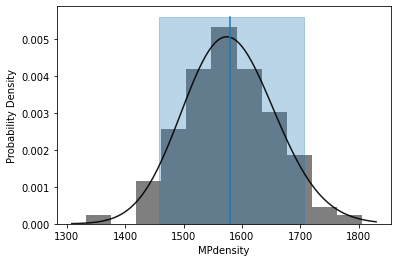

In [156]:
sim.invars['MPdensity'].addVarStat('mean')
sim.invars['MPdensity'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.plot(sim.invars['MPdensity'])


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='FI', ylabel='Probability Density'>)

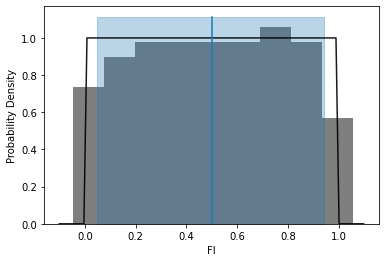

In [97]:
sim.invars['FI'].addVarStat('mean')
sim.invars['FI'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.plot(sim.invars['FI'])

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='biof_deg_rate', ylabel='Probability Density'>)

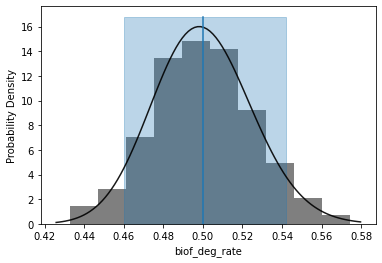

In [157]:
sim.invars['biof_deg_rate'].addVarStat('mean')
sim.invars['biof_deg_rate'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.plot(sim.invars['biof_deg_rate'])

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='MPdensity'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

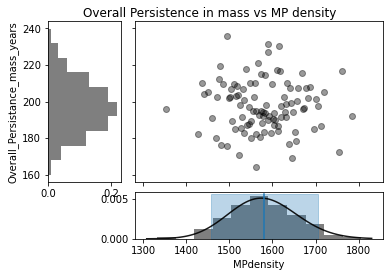

In [158]:
mc.multi_plot([sim.invars["MPdensity"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs MP density",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='MPdensity'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

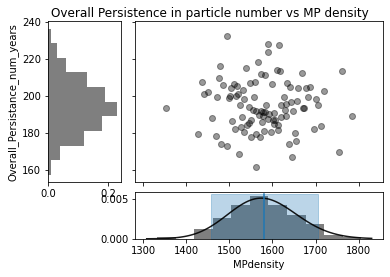

In [159]:
mc.multi_plot([sim.invars["MPdensity"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs MP density",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

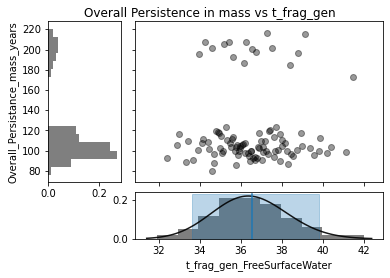

In [101]:
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs t_frag_gen",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

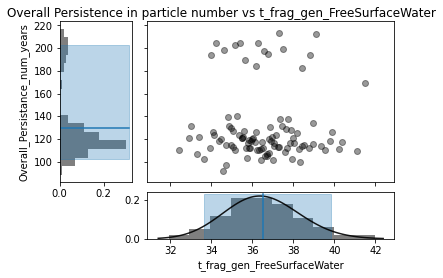

In [102]:
sim.outvars['Overall_Persistance_num_years'].addVarStat('mean')
sim.outvars['Overall_Persistance_num_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs t_frag_gen_FreeSurfaceWater",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

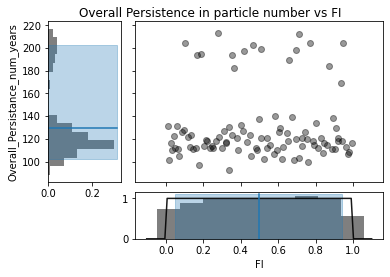

In [103]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs FI",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

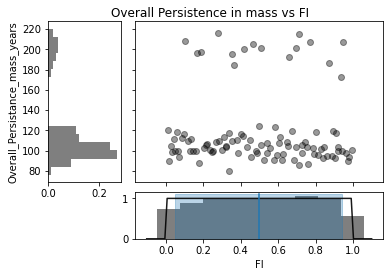

In [104]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs FI",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='MPdensity'>,
  <Axes: ylabel='Overall_Residence_time_mass_years'>,
  <Axes: >))

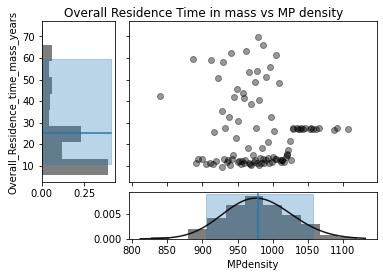

In [105]:
sim.outvars['Overall_Residence_time_mass_years'].addVarStat('mean')
sim.outvars['Overall_Residence_time_mass_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["MPdensity"],sim.outvars["Overall_Residence_time_mass_years"]],title="Overall Residence Time in mass vs MP density",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Residence_time_num_years'>,
  <Axes: >))

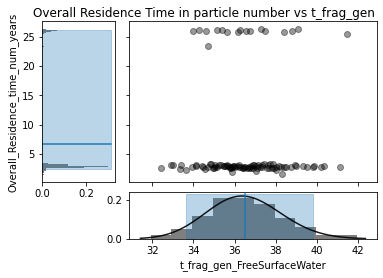

In [106]:
sim.outvars['Overall_Residence_time_num_years'].addVarStat('mean')
sim.outvars['Overall_Residence_time_num_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Residence_time_num_years"]],title="Overall Residence Time in particle number vs t_frag_gen",cov_plot=False)

(<Figure size 432x288 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Residence_time_mass_years'>,
  <Axes: >))

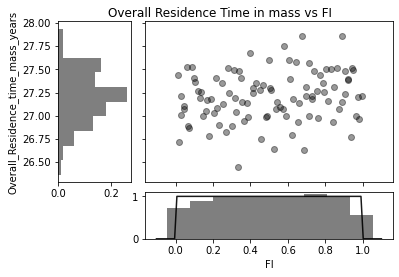

In [160]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Residence_time_mass_years"]],title="Overall Residence Time in mass vs FI",cov_plot=False)

Calculating sensitivity indices for 'Overall_Persistance_num_years'...
Calculating optimal hyperparameters Φ for 'Overall_Persistance_num_years' covariances...
L = 901.1246, Φ = [1. 1. 1. 1. 1. 1.]
L = 901.1246, Φ = [1.00000001 1.         1.         1.         1.         1.        ]
L = 901.1246, Φ = [1.         1.00000001 1.         1.         1.         1.        ]
L = 901.1246, Φ = [1.         1.         1.00000001 1.         1.         1.        ]
L = 901.1246, Φ = [1.         1.         1.         1.00000001 1.         1.        ]
L = 901.1246, Φ = [1.         1.         1.         1.         1.00000001 1.        ]
L = 901.1246, Φ = [1.         1.         1.         1.         1.         1.00000001]
L = 976.4135, Φ = [ 0.          0.          0.         18.32810244 20.44961253  0.        ]
L = 976.4135, Φ = [1.00000000e-08 0.00000000e+00 0.00000000e+00 1.83281024e+01
 2.04496125e+01 0.00000000e+00]
L = 976.4135, Φ = [0.00000000e+00 1.00000000e-08 0.00000000e+00 1.83281024e+01
 2.0

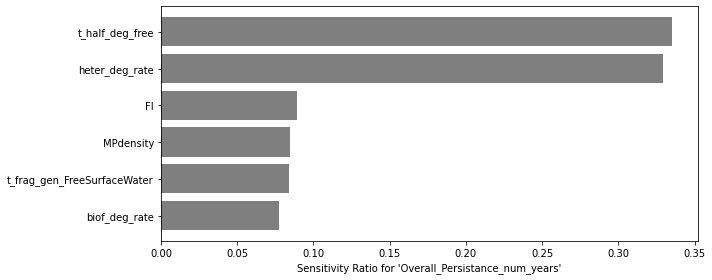

In [161]:
## Calculate and plot sensitivity indices
sim.calcSensitivities(outvarnames="Overall_Persistance_num_years",tol=1e-6,verbose=True)
fig, ax = sim.outvars['Overall_Persistance_num_years'].plotSensitivities()
fig.set_size_inches(10, 4)
plt.savefig('Overall_Persistence_time_num_sensitivities.png', dpi=100)
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Overall_Persistance_num_years', ylabel='Cumulative Probability'>)

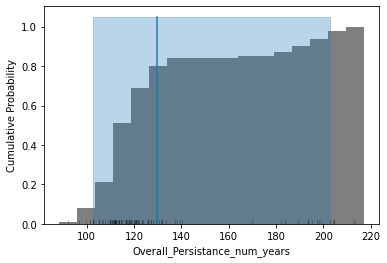

In [109]:

mc.mc_plot.plot_cdf(sim.outvars["Overall_Persistance_num_years"])

(<Figure size 432x288 with 1 Axes>, <Axes: >)

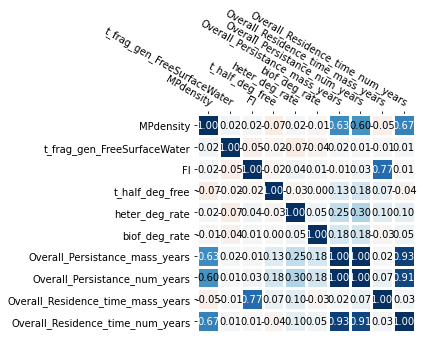

In [110]:
mc.plot_cov_corr(*sim.corr())